## 1. Pre-task: Data Preparation




### Import Dataset
* Please create a data folder and put the compas-scores-two-years.csv in to data.

* Import the COMPAS dataset as the following codes do:

In [ ]:
import pandas as pd

# Turn off an annoying warning that crops up a bunch
pd.options.mode.chained_assignment = None  # default='warn'

DATA_FOLDER = 'data/'

df = pd.read_csv(
    DATA_FOLDER + 'compas-scores-two-years.csv',
    index_col=0)

print(df.shape, " first element is data instances (rows in the CSV), second is features (columns in the CSV)")

(7214, 52)  first element is data instances (rows in the CSV), second is features (columns in the CSV)


### Apply preprocessing on data features
However not all of the rows are useable for the first round of analysis.

**From the ProPublica notebook**: There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [ ]:
# df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
#                     'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
ix = df['days_b_screening_arrest'] <= 30
ix = (df['days_b_screening_arrest'] >= -30) & ix
ix = (df['is_recid'] != -1) & ix
ix = (df['c_charge_degree'] != "O") & ix
ix = (df['score_text'] != 'N/A') & ix
df = df.loc[ix,:]
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])-pd.to_datetime(df['c_jail_in'])).apply(lambda x: x.days)
list(df)

['name',
 'first',
 'last',
 'compas_screening_date',
 'sex',
 'dob',
 'age',
 'age_cat',
 'race',
 'juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_jail_in',
 'c_jail_out',
 'c_case_number',
 'c_offense_date',
 'c_arrest_date',
 'c_days_from_compas',
 'c_charge_degree',
 'c_charge_desc',
 'is_recid',
 'r_case_number',
 'r_charge_degree',
 'r_days_from_arrest',
 'r_offense_date',
 'r_charge_desc',
 'r_jail_in',
 'r_jail_out',
 'violent_recid',
 'is_violent_recid',
 'vr_case_number',
 'vr_charge_degree',
 'vr_offense_date',
 'vr_charge_desc',
 'type_of_assessment',
 'decile_score.1',
 'score_text',
 'screening_date',
 'v_type_of_assessment',
 'v_decile_score',
 'v_score_text',
 'v_screening_date',
 'in_custody',
 'out_custody',
 'priors_count.1',
 'start',
 'end',
 'event',
 'two_year_recid',
 'length_of_stay']

Drop Asian, Native American due to lack of samples

In [ ]:
dfcut = df.loc[~df['race'].isin(['Native American','Hispanic','Asian','Other']),:]

## Task 2. Exploration in Feature Engineering
Please investigate Feature Categorization and investigation on fairness to answer the following questions:

A. **[Team, TURN THIS IN]** Pick a feature that we dropped from the model in the cell titled "Feature Categorization" to re-incorporate. The original set is in the cell previous. You may want to briefly consult this paper by Grgic-HlacaLinks. The original spreadsheet (compas-scores-two-years) might also help you interpret what the semantics of the features are.

B. **[Team, TURN THIS IN]** Why did you pick the chosen feature?

C. **[Team,  TURN THIS IN]** How might including the chosen feature help and/or harm a future model in terms of accuracy, fairness, etc?


**About the cell of Feature Catergorization**: This next cell reflects a process of elimination on the features by checking their contents. It seems any string that starts with "r" or "vr" is some parameter about the recidivism charges, while "c" is about their first charges.  Thus, "r" are all implicitly outcome variables, and would be relevant if we were doing a more complicated prediction task (i.e. if they recidivate, WHEN, for WHAT, etc).

In [ ]:
#@title Feature Categorization
# Extracting the target variable (label) 'is_recid' from the original dataframe.
labelsDF = dfcut['is_recid']

# Specifying a list of columns that represent different outcomes, scores, risk predictions, and related information.
outcomeStrings = ['is_recid', 'two_year_recid', 'violent_recid', 'is_violent_recid', # labels (target variables for different tasks)
                  'decile_score', 'decile_score.1', 'score_text', 'v_decile_score', 'v_score_text', # scores generated by some model or system
                  'v_type_of_assessment', 'type_of_assessment', # type of risk assessments
                  'r_days_from_arrest', 'r_jail_in', 'r_jail_out', # timing-related parameters for when someone was jailed
                  'r_charge_degree', 'r_charge_desc', # information about the recent charge
                  'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc' # details of violent recidivism cases
                 ]

# Removing the columns in the 'outcomeStrings' list from the original dataframe to get only the feature columns.
featuresDF = dfcut.drop(outcomeStrings, axis=1)

# Specifying a list of columns that are not deemed useful for predictive modeling.
# Removing the columns deemed non-informative.
worthlessStrings = ['name', 'first','last', 'c_case_number', 'r_case_number', # record-keeping columns related to individuals
                    'compas_screening_date', 'c_offense_date', 'r_offense_date', # dates related to offenses and screenings
                    'c_arrest_date', 'screening_date', 'v_screening_date', # additional dates
                    'days_b_screening_arrest', 'c_days_from_compas', # time intervals
                    'c_jail_in', 'c_jail_out', 'in_custody', 'out_custody', 'length_of_stay', # jail entry and exit details
                    'start', 'end', 'event', # unclear columns that are labeled as unintelligible
                    'c_charge_desc' # descriptions of charges which have too many unique values to be useful directly
                   ]
featuresDF = featuresDF.drop(worthlessStrings, axis=1)

# Removing the redundant columns.
redundantStrings = ['dob', 'age_cat', # 'dob' (date of birth) and 'age_cat' (age category) are redundant as 'age' might already capture the age information.
                    'priors_count.1', # this seems to be a duplicate or similar column to 'priors_count'.
                   ]
featuresDF = featuresDF.drop(redundantStrings, axis=1)

juvenileStrings = ['juv_fel_count', 'juv_misd_count', 'juv_other_count']
featuresDF['juv_priors'] = featuresDF.apply(lambda row: row.juv_fel_count + row.juv_misd_count + row.juv_other_count, axis=1)

# Printing the columns of the feature dataframe after all the transformations.
print(list(featuresDF))


['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'juv_priors']


### Investigation of Fairness

Out of interest, plot distribution of COMPAS scores (matches the one in the ProPublica article).

(0.5, 10.5)

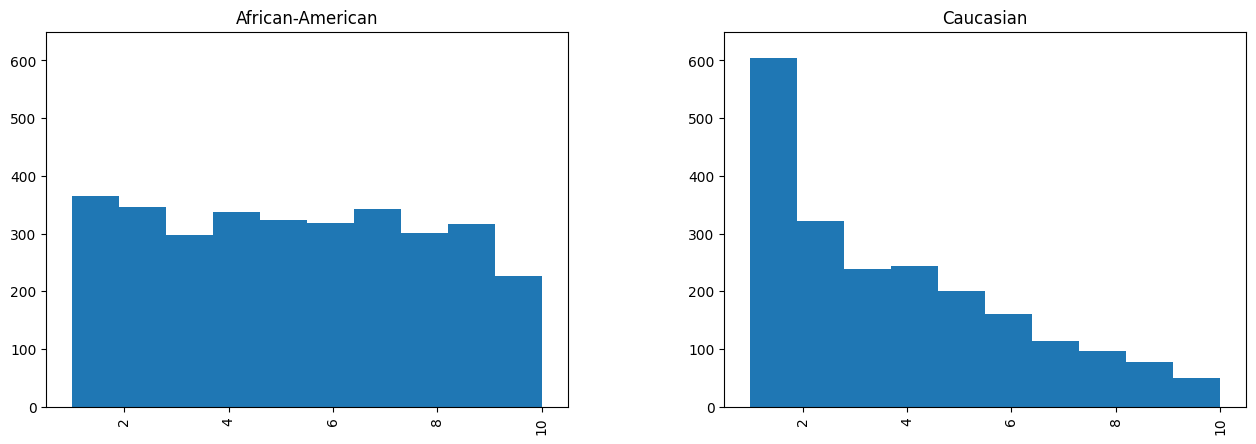

In [ ]:
df2 = df.loc[df['race'].isin(['African-American','Caucasian']),['race','decile_score']]
ax = df2.hist(column='decile_score',by='race',figsize=(15,5),**{'density':False}) # MODIFICATION from JED, was 'normed', but that is deprecated. Now 'density'
ax[0].set_ylim([0,650])
ax[1].set_ylim([0,650])
ax[0].set_xlim([.5,10.5])
ax[1].set_xlim([.5,10.5])

In order to inform the quantization, make histograms of the individuals that remain after the initial filtering

(18.0, 80.1)

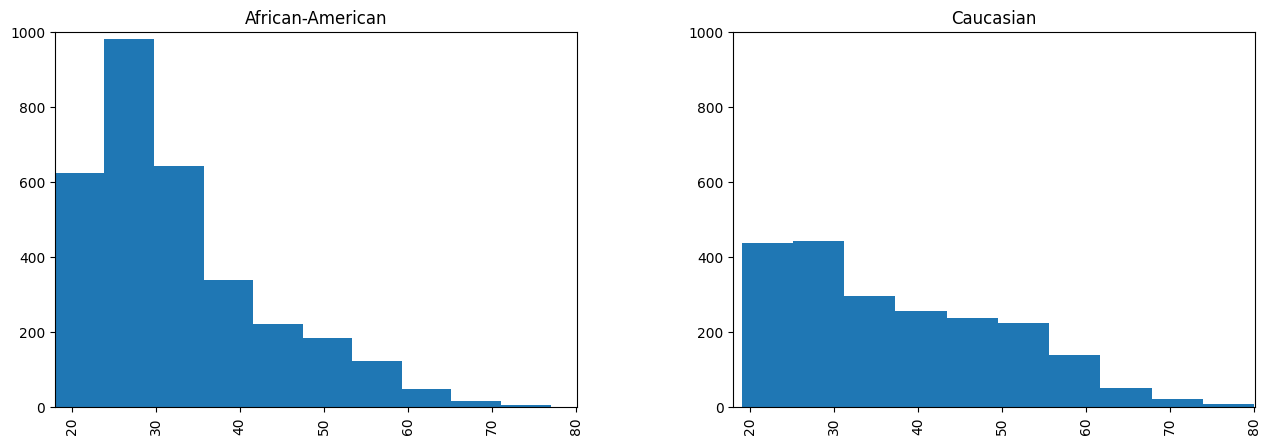

In [ ]:
ax = featuresDF.hist(column='age',by='race',figsize=(15,5),**{'density':False}) # MODIFICATION from JED, was 'normed', but that is deprecated. Now 'density'
ax[0].set_ylim([0,1000])
ax[1].set_ylim([0,1000])
ax[0].set_xlim([18,80.1])
ax[1].set_xlim([18,80.1])

(1.0, 30.5)

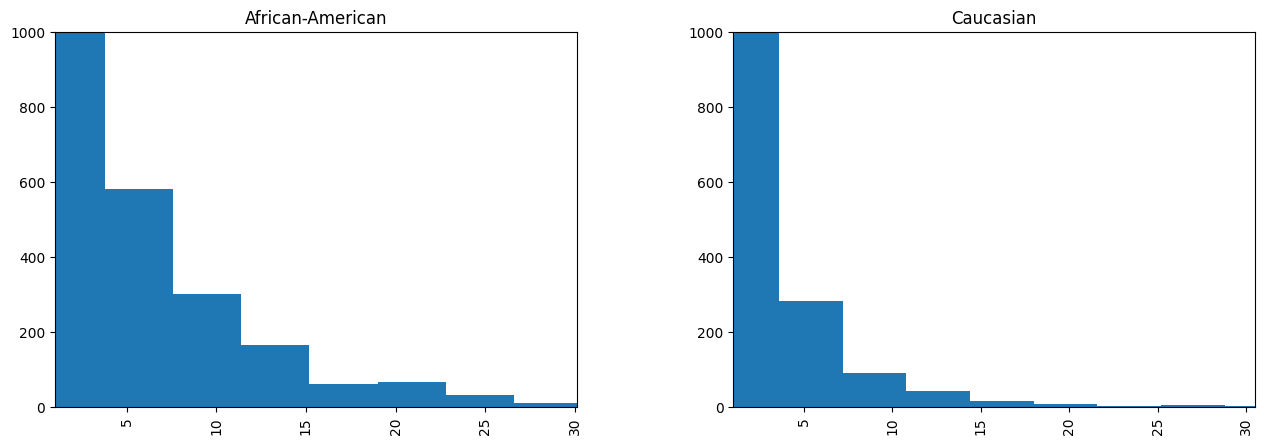

In [ ]:
ax = featuresDF.hist(column='priors_count',by='race',figsize=(15,5),**{'density':False}) # MODIFICATION from JED, was 'normed', but that is deprecated. Now 'density'
ax[0].set_ylim([0,1000])
ax[1].set_ylim([0,1000])
ax[0].set_xlim([1,30.1])
ax[1].set_xlim([1,30.5])

(1.0, 15.5)

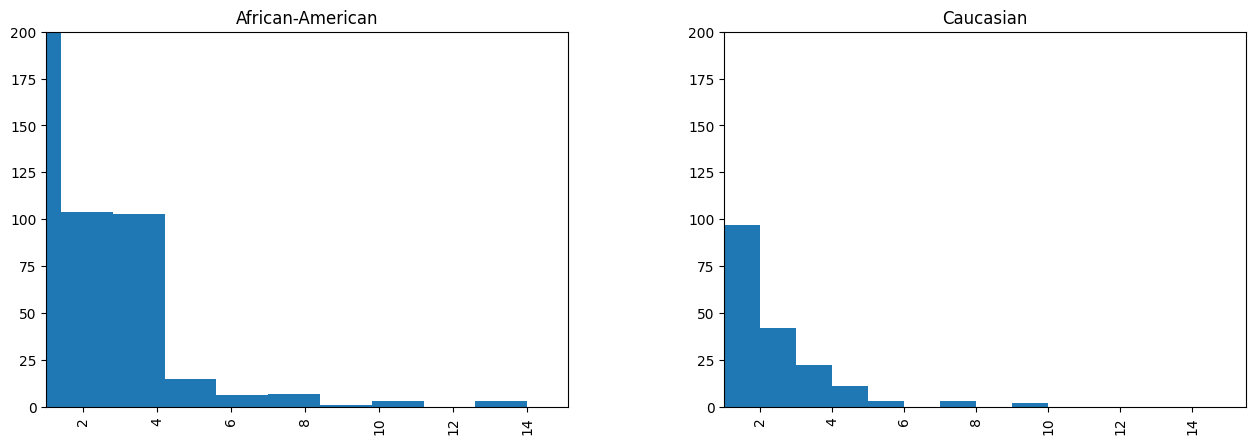

In [ ]:
ax = featuresDF.hist(column='juv_priors',by='race',figsize=(15,5),**{'density':False}) # MODIFICATION from JED, was 'normed', but that is deprecated. Now 'density'
ax[0].set_ylim([0,200])
ax[1].set_ylim([0,200])
ax[0].set_xlim([1,15.1])
ax[1].set_xlim([1,15.5])

This is some code to help automate the feature selection process, but process of elimination seemed to do the job on this data set!

## Task 3: Understanding the Feature Coefficients:
Run the code in cell of **Feature Coefficient**, then answer the following question

A. **[Team, TURN THIS IN]** Inspect the feature coefficients of this model found in the cell titled "Feature Coefficients" in the preparation notebook. Which features are predictive of which outcomes and how strongly?

**Logistic Regression Feature Coefficients**: In logistic regression, the probability of the positive class is represented as:

$$P(Y=1|X) = 1 / (1 + e^-(β_0 + β_1*X_1 + ... + β_n*X_n))$$

Each coefficient, $β_i$, indicates the change in log odds of $Y=1$ for a one-unit change in $X_i$.
- If $β_i$ is positive: An increase in $X_i$ leads to higher odds of $Y=1$.
- If $β_i$ is negative: An increase in $X_i$ leads to lower odds of $Y=1$.


In [ ]:
#@title Feature Coefficients

from sklearn.linear_model import LogisticRegression

# Step 1: Dummy Variable Creation
inputDummies = pd.get_dummies(featuresDF)
print(inputDummies.shape)
print()

# Step 2: Logistic Regression Model Training
# FIXME this part should happen above the call to get_dummies, but strings need to get removed
logistic = LogisticRegression()
logistic = logistic.fit(inputDummies, labelsDF.values.ravel())

from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(logistic, prefit=True)
RFE = selection.transform(inputDummies)
support = selection.get_support()
labels = list(inputDummies)

# Step 3: Displaying Feature Coefficients
for i in range(0,len(support)):
    print(labels[i], "\t", logistic.coef_[0][i])

(5278, 12)

age 	 -0.043051744941740556
juv_fel_count 	 -0.003140390233155686
juv_misd_count 	 -0.12630289615120266
juv_other_count 	 0.2297709663979623
priors_count 	 0.16456151265724261
juv_priors 	 0.10032768001360202
sex_Female 	 -0.043310556693081426
sex_Male 	 0.34562254643741447
race_African-American 	 0.20395021495962837
race_Caucasian 	 0.09836177478471063
c_charge_degree_F 	 0.22675824530298666
c_charge_degree_M 	 0.07555374444135426


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
featuresDF['juv_priors'].corr(featuresDF['priors_count'])

0.294305972121295

So now we have a rough idea of what features we want to include, so next we combine a few features, then filter.

Combine juvenile priors

In [ ]:
juvenileStrings = ['juv_fel_count', 'juv_misd_count', 'juv_other_count']
dfcut['juvenile priors'] = dfcut.apply(lambda row: row.juv_fel_count + row.juv_misd_count + row.juv_other_count, axis=1)



Rename charge degree and priors

In [ ]:
dfcut['charge degree'] = dfcut['c_charge_degree']
dfcut['prior convictions'] = dfcut['priors_count']

Define features by setting discriminatory features (`D_features`), binary response variable (`Y_features`) and decision features (`X_features`).

In [ ]:
D_features = ['race']
Y_features = ['is_recid']
X_features = ['age', 'charge degree','prior convictions', 'juvenile priors']

features = D_features + X_features + Y_features

Now we quantize the dataframe for the ordinal data that we care about (age, priors, and juvenile priors)

In [ ]:
def quantizePriors(x):
    if x <1:
        return 'None'
    elif x < 4:
        return '1-3'
    elif x < 7:
        return '4-6'
    elif x < 11:
        return '7-10'
    else:
        return '>10'

def quantizeJuvenilePriors(x):
    if x <1:
        return 'No'
    else:
        return 'Yes'

def quantizeAge(x):
    if x < 30:
        return '18-29'
    elif x < 40:
        return '30-39'
    elif x < 50:
        return '40-49'
    elif x < 60:
        return '50-59'
    else:
        return '>59'

def lengthenChargeDeg(x):
    if x == 'F':
        return 'Felony'
    if x == 'M':
        return 'Misdemeanor'

dfcutQ = dfcut
dfcutQ['age'] = dfcutQ['age'].apply(quantizeAge)
dfcutQ['juvenile priors'] = dfcutQ['juvenile priors'].apply(quantizeJuvenilePriors)
dfcutQ['prior convictions'] = dfcutQ['prior convictions'].apply(quantizePriors)
dfcutQ['charge degree'] = dfcutQ['charge degree'].apply(lengthenChargeDeg)

Now, our dataframe is composed of:
- 'age' (ordinal)
- 'race' (dichotomous)
- 'juvenile priors' (dichotomous)
- 'prior convictions' (ordinal)
- 'charge degree' (dichotomous)
- 'is_recid' (dichotomous) ---- Output variable

In [ ]:
df = dfcutQ[features].copy()
print(df.shape)
print(df)

(5278, 6)
                   race    age charge degree prior convictions  \
id                                                               
3      African-American  30-39        Felony              None   
4      African-American  18-29        Felony               4-6   
8             Caucasian  40-49        Felony               >10   
10            Caucasian  30-39   Misdemeanor              None   
14            Caucasian  18-29        Felony              None   
...                 ...    ...           ...               ...   
10994  African-American  30-39   Misdemeanor              None   
10995  African-American  18-29        Felony              None   
10996  African-American  18-29        Felony              None   
10997  African-American  18-29        Felony              None   
11000  African-American  30-39   Misdemeanor               1-3   

      juvenile priors  is_recid  
id                               
3                  No         1  
4                 Yes        

## Task 4: Debiasing Data Transformation

A. **[Team, TURN THIS IN]** Clearly describe ONE modification to the distortion function in the next cell (you can search "getDistortion") that you think might help the a future model to achieve higher accuracy or "better" fairness (your modification may be very simple)

B. **[Team, TURN THIS IN]** Why do you think this modification might help as described?

C. **[Each, TURN THIS IN]** In what ways and to what extent do you think this dataset is biased?

D. **[Each, TURN THIS IN]** Which pieces of evidence do you find most compelling in reaching the judgment you did in the previous question?

E. **[Each, TURN THIS IN]** Why are those pieces of evidence the most compelling to you?

Now we set the distortion metric. This function will receive the two dictionary of features X and Y corresponding to the new and old values, and return a distortion value.

In [ ]:
class Dclass():

    def categoryPriors(self, x):
        if x == 'None':
            return 0
        elif x == '1-3':
            return 1
        elif x == '4-6':
            return 2
        elif x == '7-10':
            return 3
        else:
            return 4

    def categoryJuvenilePriors(self, x):
        if x == 'No':
            return 0
        else:
            return 1

    def categoryAge(self, x):
        if x == '18-29':
            return 0
        elif x == '30-39':
            return 1
        elif x == '40-49':
            return 2
        elif x == '50-59':
            return 3
        else:
            return 4

    # distortion metric
    def getDistortion(self,vold,vnew):
        '''
        Distortion metric.

        Inputs:
        *vold : dictionary of the form {attr:value} with old values
        *vnew : dictionary of the form {attr:value} with new values

        Output
        *d : distortion value
        '''

        # value that will be returned for events that should not occur
        bad_val = 1e4

        # penalty accumulator variable
        cum_sum = 0.0

        # check each feature's transformation penalty


        # Penalize recidivism adjustments (sharply!)
        if vold['is_recid'] != vnew['is_recid']:
            cum_sum = cum_sum + 4.0

        # Penalize age adjustments
        aOld = self.categoryAge(vold['age'])
        aNew = self.categoryAge(vnew['age'])
        aDiff = np.abs(aOld - aNew)

        # Age cannot be increased or decreased in more than one category
        if aDiff > 1.0:
            return bad_val

        # Penalty of 1 if age is decreased or increased
        if aDiff > 0:
            cum_sum = cum_sum + 1.0

        # Penalize priors adjustments
        pOld = self.categoryPriors(vold['prior convictions'])
        pNew = self.categoryPriors(vnew['prior convictions'])
        pDiff = np.abs(pOld - pNew)

        # Priors cannot be changed by more than 1 category.
        if pDiff > 1.0:
            return bad_val

        # Penalty of 1 if priors is decreased or increased
        if pDiff > 0:
            cum_sum = cum_sum+1

        # Penalize juvenile priors adjustments
        jpOld = self.categoryPriors(vold['juvenile priors'])
        jpNew = self.categoryPriors(vnew['juvenile priors'])
        jpDiff = np.abs(jpOld - jpNew)

        # Priors cannot be changed by more than 1 category.
        if jpDiff > 1.0:
            return bad_val

        # Penalty of .5 if priors is decreased or increased
        if jpDiff > 0:
            cum_sum = cum_sum+.5

       # Penalize charge degree adjustments
        if vold['charge degree'] != vnew['charge degree']:
            cum_sum = cum_sum+2

        return cum_sum


*SNIP* from here on it is uninteresting details.

## If you finish Early? Task 5: Model Construction and Validation

A. **[Team, Your will TURN THIS IN with Assignment 1]** In the code, we examined 5x test-train splits throughout. Describe what this accomplishes, why that might be important, and what you see in these outputs.

In [ ]:
#@title Double click this area to collapse this massive cell
'''
Author: Jonathan Dodge
'''
import pandas as pd
import numpy as np
import json

from copy import deepcopy
from random import randint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import euclidean_distances


#The first two functions will be used to show predictions/labels from the model.  Using them allows each of the explanation function to depend slightly less on the particular data set the model was trained on
def stringPrediction(prediction):
    answerStr = ""
    if prediction:
        answerStr = "likely to reoffend"
    else:
        answerStr = "NOT likely to reoffend"
    return answerStr
def stringInstanceLabel(label):
    answerStr = ""
    if label:
        answerStr = "reoffended"
    else:
        answerStr = "did NOT reoffend"
    return answerStr


#This function will be used by various explanation functions later to show a single data instance
def showInstance(dataInstance, baseline_columns, instanceName, silent=False):
    # input: dataInstance       A row of a pandas dataframe
    # input: baseline_columns   A list of strings indicating the names of the features which are baseline
                                # meaning that they do not appear in the instance's dataframe columns
    # input: silent             Boolean, indicates whether print should occur
    # OUTPUT: list of strings, the labels of the columns for the features which were "on" for the instance
    strings = list()

    # print header row, with prediction/label
    #if not silent:
    #    print "Defendant:", instanceName

    # print features which were 'on'
    for k in range(0, len(dataInstance)):
        if dataInstance[k]:
            strings.append(dataInstance.index[k])

    droppedStrings = [] # accumulator for feature names which are baseline and describe this instance
    # find and print features which were 'off' for all categories of the feature
    for baselineHere in baseline_columns:
        overlapFound = False
        for stringHere in strings:
            # Compare the instance's descriptors with baseline.  this test is primitive, but kinda works
            if stringHere[:3] == baselineHere[:3]:
                overlapFound = True
        # if no overlap was found, then this instance is part of the baseline group for this feature
        if not overlapFound:
            droppedStrings.append(baselineHere)

    # combine the features which were "on" with the "baseline" features
    strings = strings + droppedStrings

    # sort and then rearrange the strings so they always appear in the same order
    strings.sort()
    strings[4],strings[2] = strings[2],strings[4]
    strings[1],strings[2] = strings[2],strings[1]
    strings[1],strings[0] = strings[0],strings[1]

    # print the feature names (if necessary)
    #if not silent:
    #    for featureName in strings:
    #        cutIdx = featureName.rfind("_")
    #        print "\t", featureName[0:cutIdx]+":",featureName[cutIdx+1:]
    #    print

    # json dump
    if not silent:
        caseDict = {"name" : instanceName}
        for featureName in strings:
            cutIdx = featureName.rfind("_")
            caseDict[featureName[0:cutIdx]] = featureName[cutIdx+1:]
        print(json.dumps(caseDict))
    return strings


# A helper function to quantize coefficients based on the coefficient ranges
def quantizeCoeff(coeff, maxCoeff, minCoeff):
    # input: coeff       The coefficient to quantize and convert to an output string
    # input: maxCoeff   The maximum coefficient (for quantizing)
    # input: minCoeff   The minimum coefficient (for quantizing)
    # OUTPUT: a string of "-----", "0", or "++" to describe where coeff falls in the range specified by min/max
    binCount =  11
    binRange = (maxCoeff - minCoeff)/binCount
    binIndex = (coeff - minCoeff)/binRange
    # make it so that the max value is not by itself as its own bin, since the bins are left associative, meaning shaped as |___
    if binCount == int(binIndex):
        binIndex -= 1

    # how many minuses should appear (might be negative)
    num_minuses = int(-minCoeff/binRange) - int(binIndex)

    # check the middle bucket
    if num_minuses == 0:
        return "0"

    # append the right number of -
    plusMinusString = ""
    for i in range(0,num_minuses):
        plusMinusString += "-"

    # append the right number of +
    for i in range(0,-num_minuses):
        plusMinusString += "+"

    return plusMinusString

def getDecorator(decoratorOn):
    if decoratorOn:
        return "<b>* "
    else:
        return "  "

def getDecoratorClose(decoratorOn):
    if decoratorOn:
        return "</b>"
    else:
        return "  "

#This class is a wrapper around the sklearn classifier, which we use to maintain various state we need to generate explanations.  The required state includes (but is not limited to), training examples, training labels, and feature labels.  The main reason this class is useful is that maintaining the columns that were dropped in the dummy coding is kind of a pain without maintaining some state information.
class ExplainableClassifier:
    def __init__(self, D_features, X_features, Y_features, trainExamples, baseline_columns):
        self.D_features = D_features
        self.X_features = X_features
        self.Y_features = Y_features

        self.trainLabels = trainExamples[Y_features]
        self.trainDF = pd.get_dummies(trainExamples[D_features+X_features])

        self.droppedStrings = baseline_columns
        self.trainDF = self.trainDF.drop(self.droppedStrings, axis=1)

        self.classifier = LogisticRegression()
        self.classifier.fit(self.trainDF.values,self.trainLabels.values.ravel())

    '''
    Now, we get to the explanation functions themselves.  Some explanations will take a data instance to explain in the locality surrounding that point, while others are "global," meaning they will generate essentially the same explanation for all points.

    The other main axis which we will categorize explanations on is whether it "describes" or "justifies." To elaborate, we appeal to the XAI literature review:
    The distinction between 'explanation' and 'justification' had been made by some, although it may be more appropriate to think about a justification as a type of explanation. Nevertheless, early explaining systems focused on making the what visible to the user, but not the why. Both modes of explanation are useful, but our view is that most current systems focus on justification; justifying why a specific action was taken. Yet we have advocated earlier that an important goal of explanation is to help a user develop a robust and predictive mental model of a system. Justifications may be inefficient ways of doing this, because they are local and focus on specific cases. Global explanations regarding how the system works may be needed as well, and this may serve more directly to help a user understand the workings of a system than individual justifications for particular decisions.
    '''


    #First, we have input influence based classification.  We consider this explanation global and description.  Its geometric interpretation is to give the equation for the decision boundary as a description of the classifier (implemented by describing the weight each feature is given).
    def inputInfluenceExplanation(self, instance, instanceName, silent=False):
        # input: instance           single row dataframe, instance we are explaining (not used much for this function)
        # input: silent             Boolean, indicates whether print should occur
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))
        instanceFeatures = showInstance(instance, self.droppedStrings, instanceName, silent)
        prediction = self.classifier.predict(instanceReshaped)[0]

        # print the prediction and confidence
        if not silent:
            print("Prediction:", stringPrediction(prediction))
            #print "Confidence:", str(int(max(self.classifier.predict_proba(instanceReshaped)[0])*100)) + "%"
            print

            print("The predictive model assesses an individual's profile factors in the database to predict whether or not this individual is likely to reoffend.", end="\t")
            print("How different factors influence the prediction is illustrated below.", end="\t")
            print("The more +s (-s), means a person with that factor is more (less) likely to re-offend. Factors with (0) have little impact.", end="\t")
            print("A * will appear next to features which are relevant for this individual")
            print()

        #built-in min/max function is giving me a really weird type, find it manually I guess
        maxCoeff = -1000000
        minCoeff = 1000000
        featureCoefs = self.classifier.coef_ # for other classifiers, change this line
        featureLabels = self.trainDF.columns
        for k in featureCoefs[0]:
            if k < minCoeff:
                minCoeff = k
            if k > maxCoeff:
                maxCoeff = k



        # armed with min/max feature importances, iterate through the features and quantize
        output = []
        zeroString = quantizeCoeff(0, maxCoeff, minCoeff)
        lastFeature = ""
        for k in range(0, len(featureCoefs[0])):
            # split the category label off from the feature label
            for feature in self.D_features + self.X_features:
                if feature in featureLabels[k]:
                    categoryLabel = featureLabels[k][len(feature)+1:]
                    break

            # check to see if we are still doing different categories of same feature or not
            if lastFeature != feature:
                lastFeature = feature
                output.append(feature + " :")

                # DUMMY_CODING_MOD now that we have printed the header, print the baseline category for this feature
                # baseline features have a coefficient of 0 by definition.
                for dropped in self.droppedStrings:
                    if feature in dropped:
                        output.append("\t" + getDecorator(dropped in instanceFeatures) +  dropped[len(feature)+1:] \
                                      + " (" + zeroString + ")")

            # handle the regular case of producing output for this feature and category
            plusMinusString = quantizeCoeff(featureCoefs[0][k], maxCoeff, minCoeff)
            output.append("\t" +getDecorator(instanceReshaped[0][k]) + categoryLabel + " (" + plusMinusString + ")" )

        # reorder the output list so that items appear in semantic order, then emit output
        # these lines are NOT general
        output[4],output[6] = output[6],output[4]
        output[4],output[5] = output[5],output[4]
        output[13],output[15] = output[15],output[13]
        output[13],output[14] = output[14],output[13]
        for out in output:
            print(out)


    #Next, we have Sensitivity-based explanation, which is local and justification.  Its geometric interpretation is that from a specific instance's point in feature space, we search along axis-aligned lines until we hit the decision boundary.  Thus, the implicit justification of finding that the decision point is lower than the boundary for a feature X is that the decision was made "because feature X was too low."
    def sensitivityExplanation(self, instance, instanceName, silent=False):
        # input: instance           single row dataframe, instance we are explaining (not used much for this function)
        # input: silent             Boolean, indicates whether print should occur
        # output: boolean, whether or not a single feature perturbation was found that flips the outcome.
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))
        showInstance(instance, self.droppedStrings, instanceName, silent)

        # setup some local variables and run the classifier on the input
        featureLabelStems = self.D_features + self.X_features
        featureLabels = list(self.trainDF.columns)
        prediction = self.classifier.predict(instanceReshaped)[0]

        # print the prediction and confidence
        if not silent:
            print("Prediction:", stringPrediction(prediction))
            #print("Confidence:", str(int(max(self.classifier.predict_proba(instanceReshaped)[0])*100)) + "%")
            print()

            print("The predictive model assesses an individual's profile factors in the database to predict whether or not this individual is likely to reoffend.", end="\t")
            print("The prediction is based on:")
            print()

        # Since this formulation uses categorical indicator variables, we can deep copy the instance, zero out
        # all the mutually exclusive categories, then march a bit down each category  (i.e. start with 0 priors,
        # then 1-3 priors, then 3+ priors, repeat for next feature.)
        # NOTE: One of these cases will be duplicate of the ACTUAL data instance, but the prediction won't change in that
        # case, so nothing will happen and it is fine.  This is easier than determining which feature vectors
        # are actually different.
        foundSensitiveFeature = False
        output = []
        for stem in featureLabelStems:
            # Start with a fresh copy of the instance to perturb
            perturbed = deepcopy(instanceReshaped)

            # now determine the feature index range corresponding to the feature label stem (a family of categories)
            # e.g. given the X feature "priors" we want data frame columns "priors_count_0", "priors_count_1_to_3", etc
            firstMatchIdx = 100000
            lastMatchIdx = -100000
            for i in range(0, len(featureLabels)):
                if stem in featureLabels[i]:
                    if i < firstMatchIdx:
                        firstMatchIdx = i
                    if i > lastMatchIdx:
                        lastMatchIdx = i

            # now we zero out all the relevant feature values for these mutually exclusive categories
            for j in range(firstMatchIdx, lastMatchIdx+1):
                perturbed[0][j] = 0

            #DUMMY_CODING_MOD run the classifier on the zero'd version
            newPrediction = self.classifier.predict(perturbed)
            if(prediction != newPrediction):
                for dropped in self.droppedStrings:
                    if stem in dropped:
                        foundSensitiveFeature = True
                        output.append(dropped)
            else:
                output.append("")

            # now we march a bit along each feature within these mutually exclusive categories
            for k in range(firstMatchIdx, lastMatchIdx+1):
                perturbed[0][k] = 1
                newPrediction = self.classifier.predict(perturbed)
                if(prediction != newPrediction):
                    foundSensitiveFeature = True
                    output.append(featureLabels[k])
                else:
                    output.append("")
                perturbed[0][k] = 0


        # reorder the output list so that items appear in semantic order, then emit output
        # these lines are NOT general
        output[2],output[4] = output[4],output[2]
        output[2],output[3] = output[3],output[2]
        output[9],output[11] = output[11],output[9]
        output[9],output[10] = output[10],output[9]



        #9-12 priors
        priorStart = 9
        priorEnd = 13
        # bin priors UP
        if output[priorStart] == "":
            # find the first area of sensitivity
            for firstSensitivity in range(priorStart, priorEnd + 1):
                if output[firstSensitivity] != "":
                    break

            # zero out the relevant sensitivities, and also do a sanity check that we dont have a case of
            #        positive examples | negative examples | positive examples
            # This is because are using logistic regression, which is a linear model
            for endSensitivity in range(firstSensitivity + 1, priorEnd + 1):
                if output[endSensitivity] == "":
                    pass#print("PANIC, WE HAVE NONLINEARITY (branch 1, prior)")
                else:
                    output[endSensitivity] = ""

            # make a mild adjustment to the feature that started the sequence of related sensitive features
            if output[firstSensitivity] != "":
                output[firstSensitivity] += "\" (or more)"

        # bin priors DOWN
        else:
            # find the first area of INsensitivity, and zero out the previous sensitivity as we find new ones
            for firstInsensitivity in range(priorStart, priorEnd + 1):
                if output[firstInsensitivity] == "":
                    break
                if firstInsensitivity > priorStart:
                    output[firstInsensitivity-1] = ""

            # make a mild adjustment to the feature that started the sequence of related INsensitive features
            if firstInsensitivity > priorStart+1:
                output[firstInsensitivity-1] += "\" (or fewer)"

            # do a sanity check that we dont have a case of
            #        positive examples | negative examples | positive examples
            # This is because are using logistic regression, which is a linear model
            for endInsensitivity in range(firstInsensitivity + 1, priorEnd + 1):
                if output[endInsensitivity] != "":
                    pass#print("PANIC, WE HAVE NONLINEARITY (branch 2, prior)")


        #index 2-6 age
        ageStart = 2
        ageEnd = 6
        # bin ages UP
        if output[ageStart] == "":
            # find the first area of sensitivity
            for firstSensitivity in range(ageStart, ageEnd + 1):
                if output[firstSensitivity] != "":
                    break

            # zero out the relevant sensitivities, and also do a sanity check that we dont have a case of
            #        positive examples | negative examples | positive examples
            # This is because are using logistic regression, which is a linear model
            for endSensitivity in range(firstSensitivity + 1, ageEnd + 1):
                if output[endSensitivity] == "":
                    pass#print("PANIC, WE HAVE NONLINEARITY (branch 1, age)")
                else:
                    output[endSensitivity] = ""

            # make a mild adjustment to the feature that started the sequence of related sensitive features
            if output[firstSensitivity] != "":
                output[firstSensitivity] += "\" (or older)"

        # bin ages DOWN
        else:
            # find the first area of INsensitivity, and zero out the previous sensitivity as we find new ones
            for firstInsensitivity in range(ageStart, ageEnd + 1):
                if output[firstInsensitivity] == "":
                    break
                if firstInsensitivity > ageStart:
                    output[firstInsensitivity-1] = ""

            # make a mild adjustment to the feature that started the sequence of related INsensitive features
            if firstInsensitivity > ageStart+1:
                output[firstInsensitivity-1] += "\" (or younger)"

            # do a sanity check that we dont have a case of
            #        positive examples | negative examples | positive examples
            # This is because are using logistic regression, which is a linear model
            for endInsensitivity in range(firstInsensitivity + 1, ageEnd + 1):
                if output[endInsensitivity] != "":
                    pass#print("PANIC, WE HAVE NONLINEARITY (branch 2, age)")



        # check to see if we found any feature perturbation which flips the output
        if not silent:
            newPredictString = stringPrediction(not prediction)
            for outLineNum in range(0, len(output)):
                if output[outLineNum] != "":
                    print(instanceName+"'s", output[outLineNum][0:output[outLineNum].find("_")], ":", end="\t")
                    if '\"' in output[outLineNum]:
                        print("If the individual had \""+ output[outLineNum]+\
                                    " they would have been predicted as "+ newPredictString)
                    else:
                        print("If the individual had \""+ output[outLineNum]+\
                                    "\" they would have been predicted as "+ newPredictString)

            if not foundSensitiveFeature:
                print("No single feature change was found that changes the prediction for this individual.\n")
            else:
                print("Changing other factors will not change the prediction for this individual.\n")
        return foundSensitiveFeature


    #Next is Case explanation, which is local and justification. Its geometric interpretation is that we find the nearest neighbor(s) in the training set and report their label(s).  It is possible we should hybridize with demographic explanation, depending on how complex and well covered the feature space is.  In some settings we find many exact matches in the training set for a given test instance.
    def caseExplanation(self, instance, instanceName, silent=False):
        # input: instance           single row dataframe, instance we are explaining (not used much for this function)
        # input: silent             Boolean, indicates whether print should occur
        # output: 2-tuple, first entry has exact matches in feature space, second entry also matches label space
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))
        showInstance(instance, self.droppedStrings, instanceName, silent)

        # setup some local variables and run the classifier on the input
        prediction = self.classifier.predict(instanceReshaped)[0]
        # print the prediction and confidence
        if not silent:
            print("Prediction:", stringPrediction(prediction))
            #print("Confidence:", str(int(max(self.classifier.predict_proba(instanceReshaped)[0])*100)) + "%")
            print

            print("The predictive model assesses an individual's profile factors in the database to predict whether or not this individual is likely to reoffend.", end="\t")
            print("The prediction is based on whether similar or identical cases in the past re-offended or not.", end="\t")

        # compute distances between the instance and the training set, then find the min
        distances = euclidean_distances(instanceReshaped, self.trainDF)
        minDistanceIdx = np.argmin(distances)

        # this code reports how many EXACT matches this data instance had in the training set, regardless of label
        # index [0] first because distance is returned as a matrix, since the input can be more than 1 instance
        filteredList = [i for i in distances[0] if i == 0.0]

        # distances in feature X label space
        instanceReshapedWithLabel = np.append(instanceReshaped, prediction)
        instanceReshapedWithLabel = np.asarray(instanceReshapedWithLabel).reshape(1,len(instanceReshapedWithLabel))
        trainAndLabelsDF = self.trainDF.assign(y=self.trainLabels.values.ravel()) # need this to filter on y
        distancesWithLabel = euclidean_distances(instanceReshapedWithLabel, trainAndLabelsDF)
        minDistanceIdxWithLabel = np.argmin(distancesWithLabel)

        # this code reports how many EXACT matches this data instance had in the training set, regardless of label
        # index [0] first because distance is returned as a matrix, since the input can be more than 1 instance
        filteredWithLabelList = [i for i in distancesWithLabel[0] if i == 0.0]
        if not silent:
            print("The training set contained", len(filteredList), "individuals identical to this one.")
            print(len(filteredWithLabelList), "of them", stringInstanceLabel(prediction), )
            if len(filteredList) == 0:
                print("(0%)\n")
            else:
                print("("+str(int(float(len(filteredWithLabelList))/float(len(filteredList))*100))+"%)\n")

        # now print the data instance which was determined to be the nearest neighbor in the training set
        if not silent:
            print("Nearest Neighbor in training data")
        # index [0] second because iloc returns a row of a data frame (in this case, a 1 element row containing a label)
        neighbor_name = "<NEIGHBOR>"
        strings = showInstance(self.trainDF.iloc[minDistanceIdx], self.droppedStrings, neighbor_name, silent=True)
        nnLabel = self.trainLabels.iloc[minDistanceIdx][0]

        # now we set the strings for each feature in the dataset so that we can explain with them!
        race_string = "race"
        age_string = "age"
        charge_string = "c_charge"
        priors_string = "priors"
        juv_prior_string = 'juv_prior'
        for string in strings:
            if race_string in string:
                race_string = string
            if age_string in string:
                age_string = string
            if charge_string in string:
                charge_string = string
            if priors_string in string:
                priors_string = string
            if juv_prior_string in string:
                juv_prior_string = string

        #DUMMY_CODING_MOD if the strings are not modified (found by checking containment), replace with dropped string
        for string in self.droppedStrings:
            if race_string in string:
                race_string = string
            if age_string in string:
                age_string = string
            if charge_string in string:
                charge_string = string
            if priors_string in string:
                priors_string = string
            if juv_prior_string in string:
                juv_prior_string = string

        if not silent:
            print("This decision was based on thousands of similar cases from the past.", end="\t")
            print("For example, a similar case to this individual is ", neighbor_name, \
                ", a \""+ race_string+ \
                ",\" \""+age_string+ \
                ",\" with \""+ priors_string+ \
                "\" and \""+juv_prior_string+ \
                ",\" charged with a \""+charge_string+ \
                "\".\n", instanceName, stringInstanceLabel(nnLabel) )
        return len(filteredList), len(filteredWithLabelList)


    #Next is Demographic explanation, which is global and description. Its geometric interpretation is characterizing how the training examples are distributed in feature space, which induces the classifier.
    def demographicExplanation(self, instance, instanceName, silent=False):
        # input: instance           single row dataframe, instance we are explaining (not used much for this function)
        # input: silent             Boolean, indicates whether print should occur
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))
        strings = showInstance(instance, self.droppedStrings, instanceName)

        # setup some local variables and run the classifier on the input
        featureLabelStems = self.D_features + self.X_features
        featureLabels = list(self.trainDF.columns)
        trainAndLabelsDF = self.trainDF.assign(y=self.trainLabels.values.ravel()) # need this to filter on y
        prediction = self.classifier.predict(instanceReshaped)[0]
        if not silent:
            print("Prediction:", stringPrediction(prediction))
            #print("Confidence:", str(int(max(self.classifier.predict_proba(instanceReshaped)[0])*100)) + "%")
            print()
            print("The predictive model assesses an individual's profile factors in the database to predict whether or not this individual is likely to reoffend.", end="\t")
            print("The prediction is based on the likelihood of previous cases with different profile factors re-offended or not, as illustrated below.", end="\t")
            print("A * will appear next to features which are relevant for this individual.")


        # compute summary statistics on the training data for each feature and category
        lastFeature = ""
        output = []
        for k in range(0,len(featureLabels)):
            # split the category label off from the feature label
            for feature in self.D_features + self.X_features:
                if feature in featureLabels[k]:
                    categoryLabel = featureLabels[k][len(feature)+1:]
                    break

            # check to see if we are still doing different categories of same feature or not
            if lastFeature != feature:
                lastFeature = feature
                output.append(feature+" :")

                #DUMMY_CODING_MOD compute demographics for those in the baseline feature categories
                # First, determine the dropped column name that corresponds to this family of feature categories
                labelHere = ""
                for dropped in self.droppedStrings:
                    if feature in dropped:
                        labelHere = dropped

                # now determine the feature index range corresponding to the feature label stem
                # e.g. given the X feature "priors" we want data frame columns "priors_count_0", "priors_count_1_to_3", etc
                firstMatchIdx = 100000
                lastMatchIdx = -100000
                for i in range(0, len(featureLabels)):
                    if feature in featureLabels[i]:
                        if i < firstMatchIdx:
                            firstMatchIdx = i
                        if i > lastMatchIdx:
                            lastMatchIdx = i

                # successively remove from the dataframe until only those with "0" values for all feature categories remain
                thisInstanceInBaseline = True # also determine if this instance is 0 valued for all feature categories too
                baselineDF = trainAndLabelsDF
                for j in range(firstMatchIdx, lastMatchIdx+1):
                    # successively filter the DF such that each feature is "off"
                    baselineDF = baselineDF[baselineDF[featureLabels[j]] == 0]
                    if instanceReshaped[0][j]:
                        thisInstanceInBaseline = False


                # now, the baselineDF only contains rows with ALL categories of this feature "off"
                denominator = len(baselineDF)

                # further, select the training examples which match the prediction for the given instance
                baselineDF = baselineDF.query('y=='+str(prediction))
                numerator = len(baselineDF)

                # now print the results from summary statistics on training data
                result = str(int((float(numerator)/float(denominator))*100))
                output.append("\t"+getDecorator(thisInstanceInBaseline)+result+"% of those in the "+\
                              labelHere[len(feature)+1:]+" "+feature+" group "+ stringInstanceLabel(prediction))



            # set the index based on the current feature.  Drop=false prevents the dataframe from being rearranged
            trainAndLabelsDF = trainAndLabelsDF.set_index(featureLabels[k], drop=False)

            # now that we have set the index, this will select all training examples with the "index" feature active
            kthFeatureDF = trainAndLabelsDF.loc[1]
            denominator = len(kthFeatureDF)

            # further, select the training examples which match the prediction for the given instance
            kthFeatureDF = kthFeatureDF.query('y=='+str(prediction))
            numerator = len(kthFeatureDF)

            # now print the results from summary statistics on training data
            result = str(int((float(numerator)/float(denominator))*100))
            output.append("\t"+getDecorator(instanceReshaped[0][k])+result+"% of those in the "+categoryLabel+" "\
                          +feature+" group "+stringInstanceLabel(prediction))

        # reorder the output list so that items appear in semantic order, then emit output
        # these lines are NOT general
        output[4],output[6] = output[6],output[4]
        output[4],output[5] = output[5],output[4]
        output[13],output[15] = output[15],output[13]
        output[13],output[14] = output[14],output[13]
        for out in output:
            print(out)



Read the data files (the ones tagged with _new have been transformed, the others are raw), then print the high level features we will use in this experiment

In [ ]:
path =r'data/' # use your path
lastColPlusOne = 7
train_0 = pd.read_csv(path + "train_0.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
train_1 = pd.read_csv(path + "train_1.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
train_2 = pd.read_csv(path + "train_2.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
train_3 = pd.read_csv(path + "train_3.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
train_4 = pd.read_csv(path + "train_4.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_0 = pd.read_csv(path + "test_0.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_1 = pd.read_csv(path + "test_1.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_2 = pd.read_csv(path + "test_2.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_3 = pd.read_csv(path + "test_3.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_4 = pd.read_csv(path + "test_4.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
train_new_0 = pd.read_csv(path + "train_new_0.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
train_new_1 = pd.read_csv(path + "train_new_1.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
train_new_2 = pd.read_csv(path + "train_new_2.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
train_new_3 = pd.read_csv(path + "train_new_3.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
train_new_4 = pd.read_csv(path + "train_new_4.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_new_0 = pd.read_csv(path + "test_new_0.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_new_1 = pd.read_csv(path + "test_new_1.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_new_2 = pd.read_csv(path + "test_new_2.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_new_3 = pd.read_csv(path + "test_new_3.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))
test_new_4 = pd.read_csv(path + "test_new_4.csv",index_col=None, header=0, usecols=range(1,lastColPlusOne))

TrainList=[train_0,train_1,train_2,train_3,train_4]
TestList=[test_0,test_1,test_2,test_3,test_4]
TrainNewList=[train_new_0,train_new_1,train_new_2,train_new_3,train_new_4]
TestNewList=[test_new_0,test_new_1,test_new_2,test_new_3,test_new_4]

print(list(TrainList[0]))

['race', 'age', 'charge degree', 'prior convictions', 'juvenile priors', 'is_recid']


Setup the features and their type.  D is protected features, while X is non-protected ones. Y is the output.

In [ ]:
D_features = ['race']
Y_features = ['is_recid']
X_features = ['age', 'charge degree','prior convictions', 'juvenile priors']

Baseline features are a requirement imposed by logistic regression, which compares to a baseline where all features are set to 0. Thus, dropping these columns ensure that a baseline sample is interpretable when dummy coding. Throughout the source code in this notebook, there will be tags that show a modification required by this type of dummy coding.

To determine which columns to drop, we used the median category for each feature (when possible)

In [ ]:
baseline_columns = ['race_Caucasian', 'age_40-49', 'charge degree_Felony', 'prior convictions_4-6', 'juvenile priors_No']

Next, we construct the explainable classifiers (including training dataframes) and test dataframes.

In [ ]:
classifiersRaw = []
classifiersProc = []
testDFs = []
# there are 5 sets of files, corresponding to different test/train splits of the dataset
for i in range(0,5):
    # create the classifiers for each split
    classifiersRaw.append(ExplainableClassifier(D_features,X_features,Y_features, TrainList[i], baseline_columns))
    classifiersProc.append(ExplainableClassifier(D_features,X_features,Y_features, TrainNewList[i], baseline_columns))

    # create the test dataframe for each split, being sure to drop the appropriate columns
    testDF = pd.get_dummies(TestList[i][D_features+X_features])

    # occasionally, a category does not appear, handle this case by creating a column of 0s
    for column in classifiersRaw[i].trainDF.columns:
        if column not in testDF:
            testDF[column] = 0

    testDF = testDF.drop(baseline_columns, axis=1)
    testDFs.append(testDF)

    # measure accuracy for each classifier on the testDF
    print("Split", i, "Accuracy RAW:", classifiersRaw[-1].classifier.score(testDF.values, TestList[i][Y_features]))
    print("Split", i, "Accuracy PROC:", classifiersProc[-1].classifier.score(testDF.values, TestList[i][Y_features]))
    print()

Split 0 Accuracy RAW: 0.6742424242424242
Split 0 Accuracy PROC: 0.6704545454545454

Split 1 Accuracy RAW: 0.6647727272727273
Split 1 Accuracy PROC: 0.6609848484848485

Split 2 Accuracy RAW: 0.6732954545454546
Split 2 Accuracy PROC: 0.6751893939393939

Split 3 Accuracy RAW: 0.6714015151515151
Split 3 Accuracy PROC: 0.6761363636363636

Split 4 Accuracy RAW: 0.6543560606060606
Split 4 Accuracy PROC: 0.6581439393939394



Determine the set of test data which have no matching cases in training data

In [ ]:
noMatchLists = []
for i in range(0,5):
    noMatchList = []

    for j in range(0,len(testDFs[i])):
        instance = testDFs[i].iloc[j]
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))

        rawFeatureMatch, rawLabelMatch = classifiersRaw[i].caseExplanation(testDFs[i].iloc[j], "<NAME>", silent=True)
        procFeatureMatch, procLabelMatch = classifiersProc[i].caseExplanation(testDFs[i].iloc[j], "<NAME>", silent=True)

        if rawFeatureMatch == 0 or procFeatureMatch == 0:
            noMatchList.append(j)

    noMatchLists.append(noMatchList)

print(noMatchLists)
'''
for i in range(0,len(noMatchLists)):
    for j in noMatchLists[i]:
        instance = testDFs[i].iloc[j]
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))

        #print "RAW confidence", max(classifiersRaw[i].classifier.predict_proba(instanceReshaped)[0])
        classifiersRaw[i].caseExplanation(testDFs[i].iloc[j], "<NAME>")
        classifiersProc[i].caseExplanation(testDFs[i].iloc[j], "<NAME>")
        print
#''' and None

[[6, 146, 158, 231, 673, 1030], [369, 838], [14, 526, 622, 731, 938, 971, 1019, 1049], [315, 522, 537], [15, 103, 168, 384, 551, 940]]


Determine the set of instances with disparate impact in the PROCESSED data classifier (flipping protected bit flips outcome)

In [ ]:
procDispImpactLists = [[],[],[],[],[]]

for i in range(0,5):
    for j in range(0,len(testDFs[i])):
        instance = testDFs[i].iloc[j]
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))
        perturbed = deepcopy(instanceReshaped)

        # currently, the protected bit is first and we only have 1 feature in D. Flip that bit
        if perturbed[0][0] == 1:
            perturbed[0][0] = 0
        else:
            perturbed[0][0] = 1

        firstPrediction = classifiersProc[i].classifier.predict(instanceReshaped)
        perturbedPrediction = classifiersProc[i].classifier.predict(perturbed)

        if firstPrediction != perturbedPrediction:
            procDispImpactLists[i].append(j)

print(procDispImpactLists)
'''
for i in range(0,len(procDispImpactLists)):
    for j in procDispImpactLists[i]:
        classifiersRaw[i].sensitivityExplanation(testDFs[i].iloc[j], "<NAME>")
        classifiersProc[i].sensitivityExplanation(testDFs[i].iloc[j], "<NAME>")
        print
''' and None

[[], [6, 68, 133, 166, 182, 227, 276, 340, 346, 412, 416, 425, 501, 515, 527, 548, 565, 578, 608, 641, 642, 675, 680, 779, 799, 802, 813, 862, 875, 913, 950, 963, 1004, 1015, 1054], [], [74, 311, 629], [224, 359, 391, 772, 849, 868, 896, 905, 965]]


Determine the set of instances with disparate impact in the RAW data classifier (flipping protected bit flips outcome)

In [ ]:
rawDispImpactLists = [[],[],[],[],[]]

for i in range(0,5):
    for j in range(0,len(testDFs[i])):
        instance = testDFs[i].iloc[j]
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))
        perturbed = deepcopy(instanceReshaped)

        # currently, the gender bit is first and we only have 1 feature in D. Flip that bit
        if perturbed[0][0] == 1:
            perturbed[0][0] = 0
        else:
            perturbed[0][0] = 1

        firstPrediction = classifiersRaw[i].classifier.predict(instanceReshaped)
        perturbedPrediction = classifiersRaw[i].classifier.predict(perturbed)

        if firstPrediction != perturbedPrediction:
            rawDispImpactLists[i].append(j)

print(rawDispImpactLists)
'''
for i in range(0,len(rawDispImpactLists)):
    for j in rawDispImpactLists[i]:
        classifiersRaw[i].sensitivityExplanation(testDFs[i].iloc[j], "<NAME>")
        classifiersProc[i].sensitivityExplanation(testDFs[i].iloc[j], "<NAME>")
        print
#''' and None

[[120, 153, 318, 325, 329, 330, 425, 438, 628, 718, 740, 807, 952, 992, 1042], [104, 130, 164, 294, 336, 467, 628, 658, 686, 742, 750, 840, 893, 922, 1029], [65, 110, 162, 231, 286, 361, 400, 421, 607, 621, 901, 905, 1010], [14, 15, 69, 74, 147, 174, 193, 208, 221, 311, 315, 327, 340, 341, 356, 360, 365, 368, 442, 465, 533, 537, 574, 579, 614, 626, 629, 652, 753, 776, 801, 808, 898, 920, 944, 948, 1031, 1048], [51, 224, 246, 338, 350, 359, 391, 408, 722, 738, 772, 828, 849, 868, 905, 965]]


Determine the set of instances with individual fairness concerns (two classifiers disagree on prediction)

In [ ]:
indivFairnessList = []
for i in range(0,5):
    flippedPredListForThisSplit = []
    # get lists of the raw predictions and subtract them
    rawPredictions = classifiersRaw[i].classifier.predict(testDFs[i].values)
    procPredictions = classifiersProc[i].classifier.predict(testDFs[i].values)
    difference = rawPredictions - procPredictions

    # now count the number of nonzero entries
    flippedPredictions = 0
    for j in range(0, len(difference)):
        if difference[j] != 0:
            flippedPredListForThisSplit.append(j)

    indivFairnessList.append(flippedPredListForThisSplit)

print(indivFairnessList)
'''
for i in range(0,len(indivFairnessList)):
    for j in indivFairnessList[i]:
        classifiersRaw[i].sensitivityExplanation(testDFs[i].iloc[j], "<NAME>")
        classifiersProc[i].sensitivityExplanation(testDFs[i].iloc[j], "<NAME>")
        print
#''' and None

[[120, 325, 330, 360, 461, 494, 628, 717, 740, 807, 952, 973, 992, 998], [40, 68, 104, 130, 133, 148, 166, 172, 227, 243, 276, 294, 412, 420, 425, 467, 471, 494, 589, 608, 658, 680, 686, 750, 779, 802, 813, 840, 846, 893, 913, 963], [162, 400, 421, 607, 905, 1010], [15, 69, 74, 147, 221, 311, 442, 574, 626, 629, 753, 898, 920, 944, 1048], [193, 202, 212, 224, 338, 350, 359, 391, 408, 500, 715, 772, 828, 849, 851, 861, 868, 875, 879, 905, 923, 965, 989, 1053]]


Determine the set of instances with NULL sensitivity explanations (and thus are not interesting and should be stricken from the experiment)

In [ ]:
nullExpLists = []
for i in range(0,5):
    nullListHere = []
    for j in range(0,len(testDFs[i])):
        instance = testDFs[i].iloc[j]
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))

        if not classifiersRaw[i].sensitivityExplanation(instance, "<NAME>", silent=True):
            nullListHere.append(j)

        elif not classifiersProc[i].sensitivityExplanation(instance, "<NAME>", silent=True):
            nullListHere.append(j)
    nullExpLists.append(nullListHere)

print(nullExpLists)
'''
for i in range(0,len(nullExpLists)):
    for j in nullExpLists[i]:
        classifiersRaw[i].sensitivityExplanation(testDFs[i].iloc[j], "<NAME>")
        classifiersProc[i].sensitivityExplanation(testDFs[i].iloc[j], "<NAME>")
        print
#''' and None

[[35, 50, 101, 115, 168, 182, 208, 257, 266, 267, 292, 306, 308, 316, 328, 347, 379, 380, 382, 464, 534, 536, 578, 608, 618, 633, 638, 656, 657, 793, 814, 842, 865, 867, 871, 875, 879, 881, 953, 964, 980, 984, 997, 1014], [59, 121, 145, 215, 283, 291, 299, 343, 385, 395, 424, 446, 478, 479, 519, 524, 525, 531, 546, 550, 580, 587, 610, 624, 638, 653, 676, 708, 724, 741, 759, 766, 769, 795, 878, 894, 901, 915, 967, 977, 985, 991, 1024, 1045], [51, 63, 129, 137, 151, 178, 232, 276, 288, 307, 338, 390, 469, 483, 518, 687, 773, 804, 846, 1011], [4, 21, 37, 48, 54, 202, 229, 318, 321, 383, 390, 421, 467, 468, 527, 529, 541, 604, 609, 740, 869, 936, 985, 1032, 1034, 1051], [12, 27, 62, 64, 91, 93, 121, 153, 264, 266, 360, 390, 411, 416, 443, 445, 460, 467, 564, 565, 568, 679, 685, 728, 732, 753, 755, 797, 809, 832, 843, 950, 966]]


Lets make lists for sampling!. We will take 5 groups
- samples where the two classifiers differ on prediction (individual fairness) AND the RAW classifier is sensitive to the protected bit (disparate impact)
- same as above, but for PROCESSED classifier
- samples with individual fairness concerns ONLY
- samples with RAW disparate impact ONLY
- samples with PROCESSED disparate impact ONLY
- samples with no disparate impact or individual fairness concerns

In [ ]:
import random
drawIndivFairnessONLY = 10000
drawProcImpactAndIndivFairness = 10000
drawRawImpactAndIndivFairness = 10000
drawProcImpactONLY = 10000
drawRawImpactONLY = 10000
drawNoImpactOrIndivFairness = 2

unfairONLYSample = []
procImpactONLYSample = []
rawImpactONLYSample = []
procBothSample = []
rawBothSample = []
noneSample = []

random.seed(1739)

# for each data split, determine our sampling pools via set difference, intersection, and union
for i in range(0,5):
    allList = range(0,len(testDFs[i]))
    nullSet = set(nullExpLists[i])
    nonNullSet = set(allList) - nullSet
    unfairMaybeNullSet = set(indivFairnessList[i])
    rawMaybeNullImpactSet = set(rawDispImpactLists[i])
    procMaybeNullImpactSet = set(procDispImpactLists[i])

    # None of these will contain NULL explanations for sensitivity because of the above construction
    indivFairnessSet = unfairMaybeNullSet - nullSet
    procImpactSet = procMaybeNullImpactSet - nullSet
    rawImpactSet = rawMaybeNullImpactSet - nullSet

    # These are the pools we will sample from
    procBothSet = indivFairnessSet & procImpactSet
    rawBothSet = indivFairnessSet & rawImpactSet
    procImpactONLYSet = procImpactSet - procBothSet
    rawImpactONLYSet = rawImpactSet - rawBothSet
    unfairONLYSet = (indivFairnessSet - procBothSet) - rawBothSet
    noneSet = nonNullSet - (indivFairnessSet | procImpactSet | rawImpactSet)

    # Now convert sets to list, shuffle, and slice
    unfairONLYSet = list(unfairONLYSet)
    random.shuffle(unfairONLYSet)
    unfairONLYSample.append(unfairONLYSet[-drawIndivFairnessONLY:])

    procBothSet = list(procBothSet)
    random.shuffle(procBothSet)
    procBothSample.append(procBothSet[-drawProcImpactAndIndivFairness:])

    rawBothSet = list(rawBothSet)
    random.shuffle(rawBothSet)
    rawBothSample.append(rawBothSet[-drawRawImpactAndIndivFairness:])

    procImpactONLYSet = list(procImpactONLYSet)
    random.shuffle(procImpactONLYSet)
    procImpactONLYSample.append(procImpactONLYSet[-drawProcImpactONLY:])

    rawImpactONLYSet = list(rawImpactONLYSet)
    random.shuffle(rawImpactONLYSet)
    rawImpactONLYSample.append(rawImpactONLYSet[-drawRawImpactONLY:])

    noneSet = list(noneSet)
    random.shuffle(noneSet)
    noneSample.append(noneSet[-drawNoImpactOrIndivFairness:])

    print("SPLIT#", i, "----------------------------------")
    print(len(allList), "Total" )
    print(len(nullExpLists[i]), "null Explanations")
    print(len(unfairONLYSet), "unfairONLYSet", unfairONLYSample[-1:][0])
    print(len(procImpactONLYSet), "procImpactONLYSet", procImpactONLYSample[-1:][0])
    print(len(rawImpactONLYSet), "rawImpactONLYSet", rawImpactONLYSample[-1:][0])
    print(len(procBothSet), "procBothSet", procBothSample[-1:][0])
    print(len(rawBothSet), "rawBothSet", rawBothSample[-1:][0])
    print(len(noneSet), "noneSet", noneSample[-1:][0])
    print()

print("unfairONLYSample", unfairONLYSample)
print("procImpactONLYSample", procImpactONLYSample)
print("rawImpactONLYSample", rawImpactONLYSample)
print("procBothSample", procBothSample)
print("rawBothSample", rawBothSample)
print("noneSample", noneSample)


SPLIT# 0 ----------------------------------
1056 Total
44 null Explanations
6 unfairONLYSet [973, 494, 998, 461, 717, 360]
0 procImpactONLYSet []
7 rawImpactONLYSet [425, 329, 153, 1042, 438, 718, 318]
0 procBothSet []
8 rawBothSet [628, 992, 330, 740, 952, 807, 325, 120]
991 noneSet [666, 673]

SPLIT# 1 ----------------------------------
1056 Total
44 null Explanations
9 unfairONLYSet [420, 243, 846, 172, 148, 589, 494, 471, 40]
21 procImpactONLYSet [675, 340, 1004, 548, 950, 1015, 346, 641, 501, 527, 862, 1054, 182, 565, 642, 6, 515, 578, 799, 416, 875]
6 rawImpactONLYSet [922, 336, 742, 164, 1029, 628]
14 procBothSet [425, 779, 802, 813, 133, 680, 68, 412, 227, 913, 963, 276, 166, 608]
9 rawBothSet [750, 840, 686, 658, 893, 104, 467, 294, 130]
953 noneSet [644, 630]

SPLIT# 2 ----------------------------------
1056 Total
20 null Explanations
0 unfairONLYSet []
0 procImpactONLYSet []
7 rawImpactONLYSet [65, 286, 361, 621, 901, 110, 231]
0 procBothSet []
6 rawBothSet [1010, 421, 162, 

QUESTION: Are the outcomes balanced? if not we need to place the decision threshold at a location other than .5 OR trim rows from the training set so that they are

ANSWER: balanced enough!

In [ ]:
print("split\tClass\tTotalExamples\t+Examples\tFraction")
for i in range(0,5):
    rawTotalExamples = len(classifiersRaw[i].trainLabels)
    rawPositiveExamples = len(classifiersRaw[i].trainLabels.query('is_recid==1'))
    print(i,"\tRAW\t", rawTotalExamples, "\t", rawPositiveExamples, "\t", float(rawPositiveExamples)/float(rawTotalExamples))

    procTotalExamples = len(classifiersProc[i].trainLabels)
    procPositiveExamples = len(classifiersProc[i].trainLabels.query('is_recid==1'))
    print(i,"\tPROC\t", procTotalExamples, "\t", procPositiveExamples, "\t", float(procPositiveExamples)/float(procTotalExamples))


split	Class	TotalExamples	+Examples	Fraction
0 	RAW	 4222 	 2110 	 0.49976314542870676
0 	PROC	 4222 	 2098 	 0.49692089057318806
1 	RAW	 4222 	 2099 	 0.4971577451444813
1 	PROC	 4222 	 2084 	 0.4936049265750829
2 	RAW	 4222 	 2132 	 0.5049739459971577
2 	PROC	 4222 	 2153 	 0.5099478919943154
3 	RAW	 4222 	 2094 	 0.49597347228801514
3 	PROC	 4222 	 2085 	 0.4938417811463761
4 	RAW	 4222 	 2117 	 0.5014211274277593
4 	PROC	 4222 	 2105 	 0.49857887257224065


QUESTION: What fraction of test examples have non-null sensitivity explanations? How confident is the classifier in cases where the sensitivity explanation is NULL and in cases where it is not NULL (label for this is "Exp")

Answer: Based on the average and MIN confidence scores for samples which had a NULL sensitivity explanation, "If the explanation is NULL, the classifier is quite confident." However, based on the average and MAX scores for samples which had a non-NULL sensitivity explanation, the reverse implication does not hold.  Note how the max confidence scores for non-NULL explanations reaches up above 90%.  Might be worth making a box plot or histogram of these distributions

In [ ]:
print("Null Explanations and confidence range for Null/explained cases -- report")
print("Split\tClassifier\tFreq\tPercentage\t Avg Conf (NULL)\t Min Conf (NULL)\t Avg Conf (Exp)\t Max Conf (Exp)")
for i in range(0,5):
    rawNullConfidenceList = []
    procNullConfidenceList = []
    rawExpConfidenceList = []
    procExpConfidenceList = []
    for j in range(0,len(testDFs[i])):
        instance = testDFs[i].iloc[j]
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))

        # if the sensitivity explanation is NULL, append the confidence to one list, otherwise append to the other
        if not classifiersRaw[i].sensitivityExplanation(instance, "<NAME>", silent=True):
            rawNullConfidenceList.append(max(classifiersRaw[i].classifier.predict_proba(instanceReshaped)[0]))
        else:
            rawExpConfidenceList.append(max(classifiersRaw[i].classifier.predict_proba(instanceReshaped)[0]))

        # same deal for the classifier trained on processed data
        if not classifiersProc[i].sensitivityExplanation(instance, "<NAME>", silent=True):
            procNullConfidenceList.append(max(classifiersProc[i].classifier.predict_proba(instanceReshaped)[0]))
        else:
            procExpConfidenceList.append(max(classifiersProc[i].classifier.predict_proba(instanceReshaped)[0]))

    # print some summary statistics on that distribution of confidences
    print(i, "\t*RAW*\t", len(rawNullConfidenceList), end="\t")
    print("\t"+str(int(float(len(rawNullConfidenceList))/float(len(testDFs[i]))*100))+"%", end="\t")
    if len(rawNullConfidenceList) != 0:
        print("\t",str(int(sum(rawNullConfidenceList)/len(rawNullConfidenceList)*100))+"%", end="\t")
        print("\t",str(int(min(rawNullConfidenceList)*100))+"%", end="\t")
    else:
        print("\t0%\t0%", end="\t")

    print("\t",str(int(sum(rawExpConfidenceList)/len(rawExpConfidenceList)*100))+"%", end="\t")
    print("\t",str(int(max(rawExpConfidenceList)*100))+"%")

    print(i, "\t*PROC*\t", len(procNullConfidenceList), end="\t")
    print("\t"+str(int(float(len(procNullConfidenceList))/float(len(testDFs[i]))*100))+"%", end="\t")
    if len(procNullConfidenceList) != 0:
        print("\t",str(int(sum(procNullConfidenceList)/len(procNullConfidenceList)*100))+"%", end="\t")
        print("\t",str(int(min(procNullConfidenceList)*100))+"%", end="\t")
    else:
        print("\t0%\t0%", end="\t")
    print("\t",str(int(sum(procExpConfidenceList)/len(procExpConfidenceList)*100))+"%", end="\t")
    print("\t",str(int(max(procExpConfidenceList)*100))+"%")

Null Explanations and confidence range for Null/explained cases -- report
Split	Classifier	Freq	Percentage	 Avg Conf (NULL)	 Min Conf (NULL)	 Avg Conf (Exp)	 Max Conf (Exp)
0 	*RAW*	 44		4%		 85%		 79%		 66%		 87%
0 	*PROC*	 37		3%		 87%		 82%		 67%		 89%
1 	*RAW*	 38		3%		 87%		 82%		 66%		 88%
1 	*PROC*	 44		4%		 86%		 77%		 66%		 89%
2 	*RAW*	 20		1%		 89%		 88%		 66%		 87%
2 	*PROC*	 20		1%		 90%		 88%		 66%		 88%
3 	*RAW*	 19		1%		 90%		 89%		 66%		 89%
3 	*PROC*	 26		2%		 92%		 91%		 66%		 87%
4 	*RAW*	 28		2%		 90%		 87%		 66%		 89%
4 	*PROC*	 24		2%		 90%		 87%		 65%		 87%


How many exact matches are typical? Output will be in histograms, paired horizontally in terms of processed/raw classifier.  Vertical arrangement is given by the split.

Case-based explanation investigation: histogram for # exact feature matches  -- report







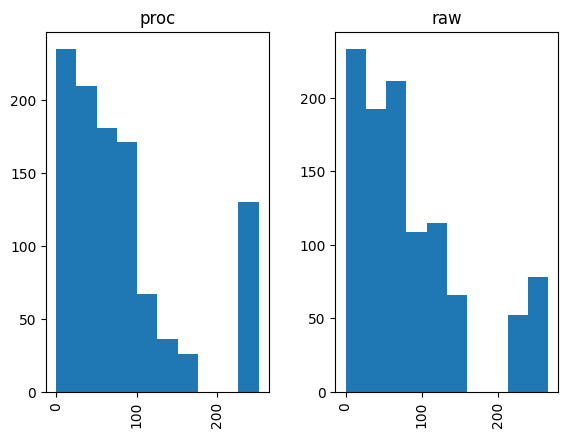

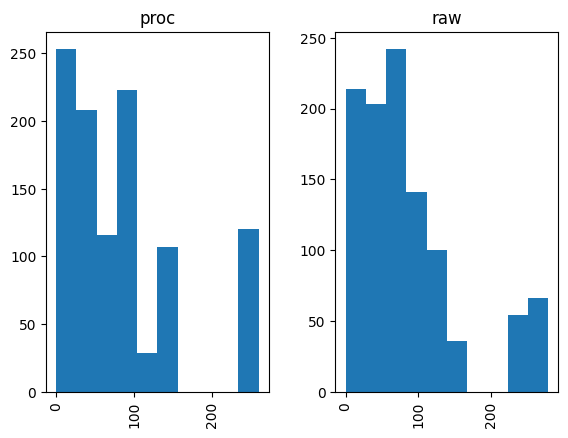

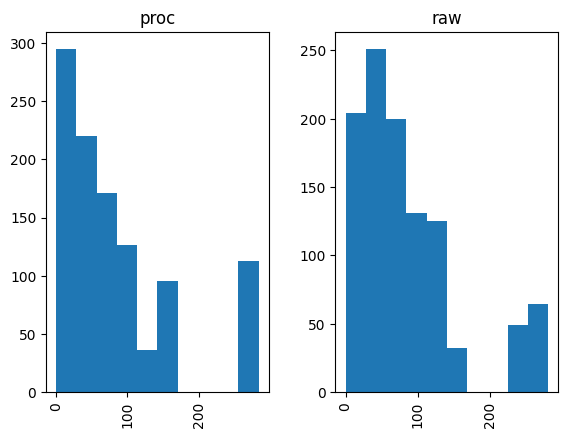

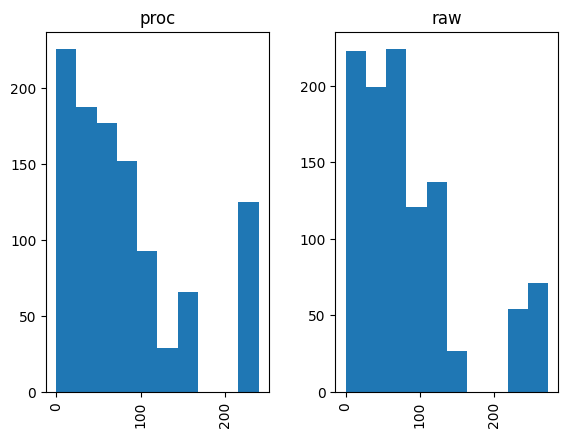

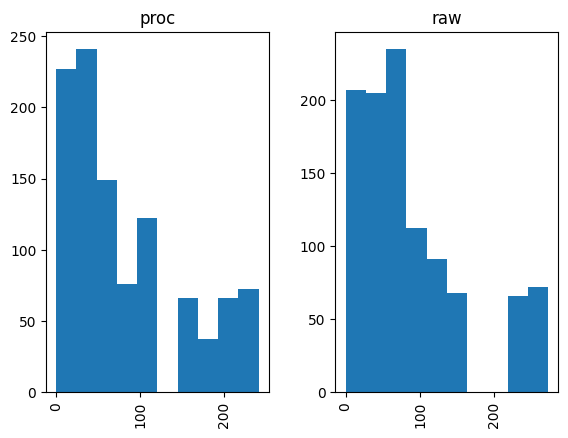

In [ ]:
print("Case-based explanation investigation: histogram for # exact feature matches  -- report")
for i in range(0,5):
    matchList = []

    for j in range(0,len(testDFs[i])):
        instance = testDFs[i].iloc[j]
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))

        rawFeatureMatch, _ = classifiersRaw[i].caseExplanation(testDFs[i].iloc[j], "<NAME>", silent=True)
        procFeatureMatch, _ = classifiersProc[i].caseExplanation(testDFs[i].iloc[j], "<NAME>", silent=True)

        matchList.append(["raw", rawFeatureMatch])
        matchList.append(["proc", procFeatureMatch])

    df = pd.DataFrame(matchList)

    df.columns = ['classifier', 'match count']

    ax = df.hist(by="classifier", bins=10)
    print()

Notably, most of the case based explanations have >50% of those with exact feature match also being exact feature + label match.  However, there will be times when this sort of "justification" fails.

Case-based explanation investigation: histogram for % exact feature matches which have label == prediction -- report


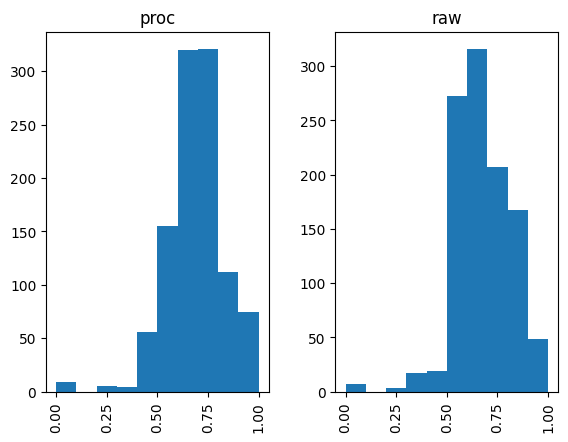

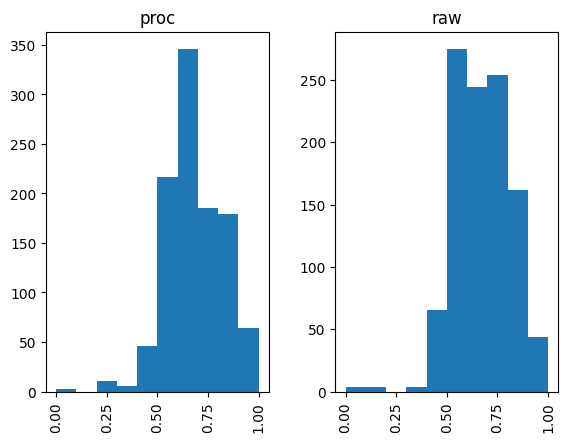

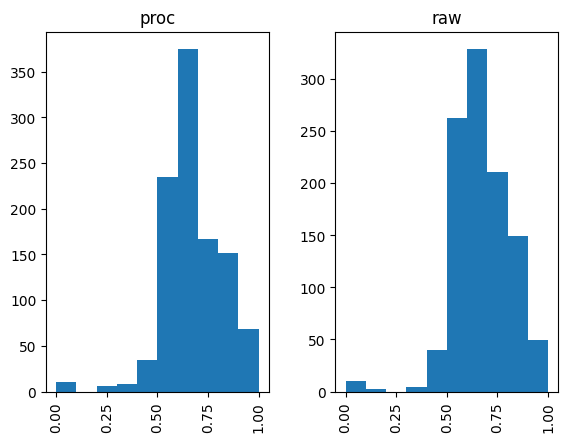

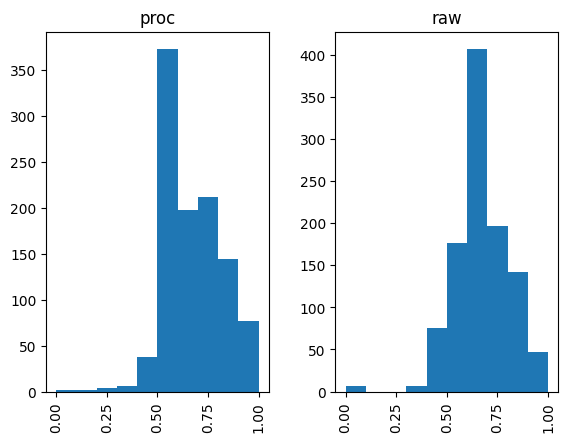

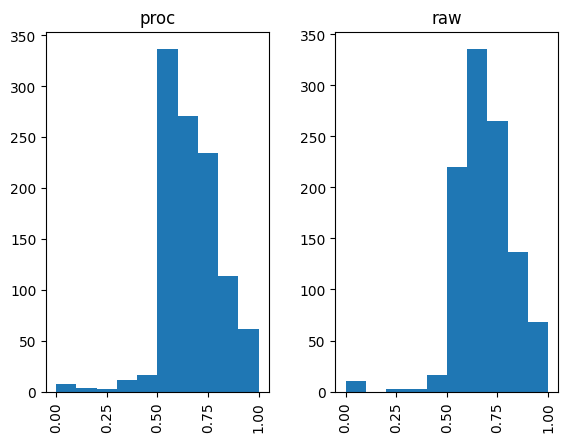

In [ ]:
print("Case-based explanation investigation: histogram for % exact feature matches which have label == prediction -- report")
for i in range(0,5):
    matchPercentList = []

    for j in range(0,len(testDFs[i])):
        instance = testDFs[i].iloc[j]
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))

        rawFeatureMatch, rawLabelMatch = classifiersRaw[i].caseExplanation(testDFs[i].iloc[j], "<NAME>", silent=True)
        procFeatureMatch, procLabelMatch = classifiersProc[i].caseExplanation(testDFs[i].iloc[j], "<NAME>", silent=True)

        if rawFeatureMatch != 0:
            matchPercentList.append(["raw", float(rawLabelMatch)/float(rawFeatureMatch)])
        else:
            matchPercentList.append(["raw", 0])
        if procFeatureMatch != 0:
            matchPercentList.append(["proc", float(procLabelMatch)/float(procFeatureMatch)])
        else:
            matchPercentList.append(["proc", 0])

    df = pd.DataFrame(matchPercentList)

    df.columns = ['classifier', 'match%']

    ax = df.hist(by="classifier", bins=10)

How does applying the preprocess impact confidences? Perhaps it move points away/closer to the decision boundary?

Answer, appears to adjust things with no discernable pattern.

Confidence histograms -- report


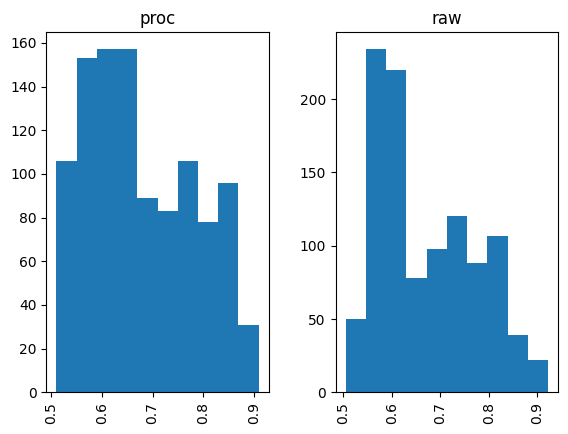

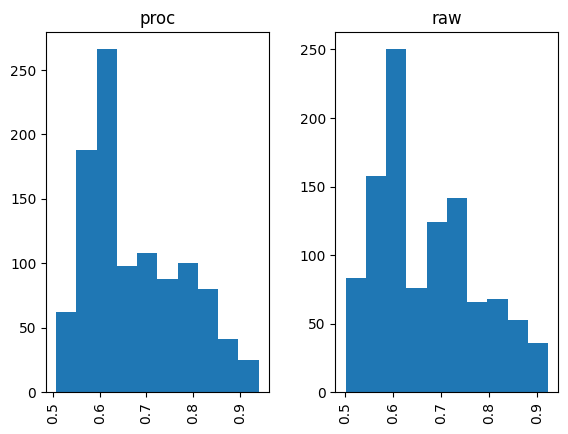

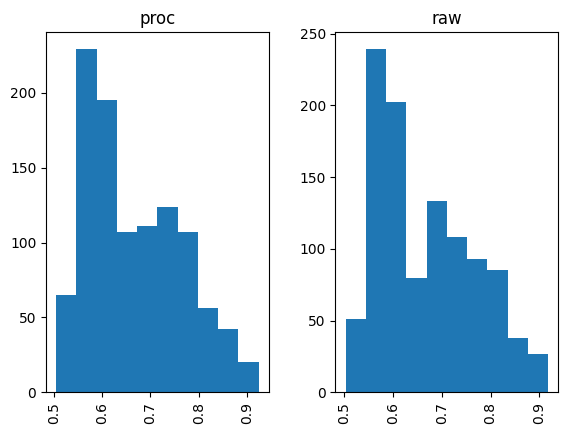

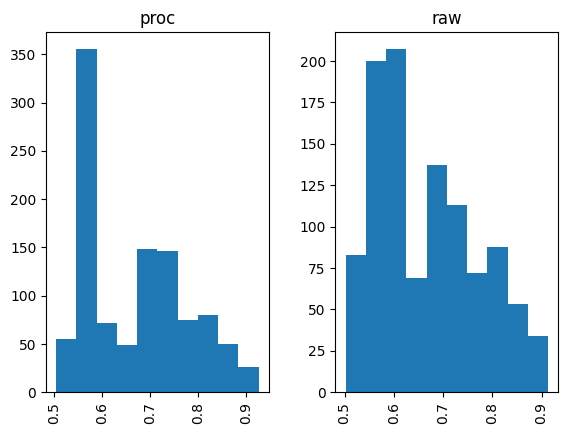

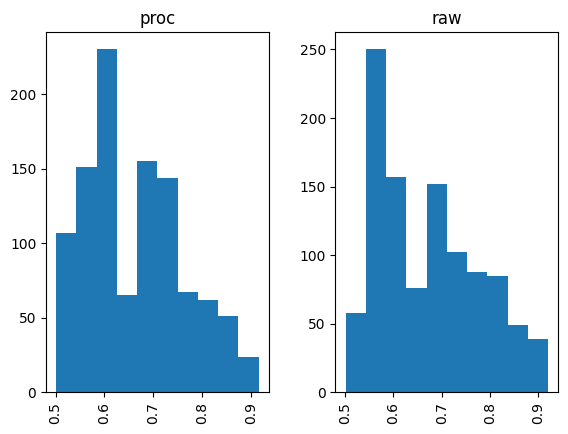

In [ ]:
print("Confidence histograms -- report")
for i in range(0,5):
    confList = []
    for j in range(0,len(testDFs[i])):
        instance = testDFs[i].iloc[j]
        instanceReshaped = np.asarray(instance).reshape(1,len(instance))

        rawConfidence = max(classifiersRaw[i].classifier.predict_proba(instanceReshaped)[0])
        procConfidence = max(classifiersProc[i].classifier.predict_proba(instanceReshaped)[0])

        confList.append(["raw", rawConfidence])
        confList.append(["proc", procConfidence])

    df = pd.DataFrame(confList)
    df.columns = ['classifier', 'confidence']

    #print df
    ax = df.hist(by="classifier", bins=10)